Code to classify the floats into clusters using Nick's pre-defined clusters as the labeled data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import zipfile
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import sys
sys.path.append('../')
from utils.get_season import get_season
from xgboost import XGBClassifier
import pickle

In [2]:
#read in data
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv("../../data/satData_clusters.csv",parse_dates=['date'], date_parser=date_parser)
df.head()

,float,cluster,cycleNumber,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED
0,1902303,NaN,1,2021-05-06 02:03:16,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213
1,1902303,NaN,2,2021-05-06 19:32:57,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114
2,1902303,NaN,3,2021-05-07 20:05:38,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105
3,1902303,NaN,4,2021-05-08 22:42:52,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087
4,1902303,NaN,5,2021-05-09 20:29:00,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090


In [3]:
#Create the unique ID for each float/cycle - these will be the unique observations
df['float_cycle'] = df['float'].map(str)+'_'+df['cycleNumber'].map(str)

In [4]:
# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

In [5]:
df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,float_cycle
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213,1902303_1
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114,1902303_2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105,1902303_3
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087,1902303_4
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090,1902303_5


In [6]:
#Columns of interest: 'float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443'
#Read in dataframe with satellite data
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
sat_df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
sat_df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [7]:
#Keep CHLA by depth data for later analysis after clustering
chla_distribution = sat_df[['float','cycleNumber','PRES','CHLA']]
#Create the unique ID for each float/cycle - these will be the unique observations
chla_distribution['float_cycle'] = chla_distribution['float'].map(str)+'_'+chla_distribution['cycleNumber'].map(str)
chla_distribution = chla_distribution.drop(['float','cycleNumber'], axis=1)
chla_distribution = chla_distribution[chla_distribution['PRES'] <= 250]

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_57481/3322222213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chla_distribution['float_cycle'] = chla_distribution['float'].map(str)+'_'+chla_distribution['cycleNumber'].map(str)


In [8]:
## keep only columns of interest:
sat_df = sat_df[['float', 'cycleNumber', 'sat_chl','sat_sst', 'sat_poc','sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']].drop_duplicates()

In [9]:
#Create the unique ID for each float/cycle - these will be the unique observations
sat_df['float_cycle'] = sat_df['float'].map(str)+'_'+sat_df['cycleNumber'].map(str)
sat_df = sat_df.drop(['float','cycleNumber'], axis=1)

In [10]:
#Join the cluster data with the satellite data on float/cycle
cluster_df = df.merge(sat_df, on='float_cycle', how='left')
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,LT_SAT_BBP_MED,float_cycle,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.002213,1902303_1,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.002114,1902303_2,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.002105,1902303_3,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.002087,1902303_4,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.002090,1902303_5,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475


In [11]:
#Double check that floats may belong to multiple clusters (different cycles affect this)
test = cluster_df[['float','cluster']].drop_duplicates().dropna()
print(len(test), ' unique float/cluster combos')
print(len(test['float'].unique()), ' unique floats')

234  unique float/cluster combos
204  unique floats


In [12]:
# Data preprocessing - change the date to a datetime index
cluster_df['month'] = cluster_df['date'].apply(lambda x: x.month)

In [13]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [14]:
#Add column for seasonality
cluster_df['season'] = cluster_df.apply(lambda x: get_season(x, month_seasons_dict), axis=1)

In [15]:
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980,5,2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950,5,2
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040,5,2
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475,5,2


In [16]:
#Drop data not in our set: 
cluster_df = cluster_df.drop(['MO_SAT_SST', 'MO_SAT_CHL',
       'MO_SAT_BBP', 'LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD',
       'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED'], axis=1)

Separate data into the train/test data and the new data for predictions

In [17]:
new_data = cluster_df[cluster_df['cluster'].isna()]
model_data = cluster_df[-cluster_df['cluster'].isna()]

In [18]:
#Add bins to stratify the data cut into train/test
model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_57481/3165825513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_57481/3165825513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))


In [19]:
test_model_data = model_data.dropna()
len(model_data) - len(test_model_data)

6081

In [20]:
model_data = model_data.dropna(subset=['latitude','longitude','season'])

In [21]:
#Sample 1 observation for each season/lat/lon for the test set
test_set = model_data.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(1)).reset_index(drop=True)
#Remove these observations from the train data
train_set = model_data[-model_data['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')
#Now pull from train_set and sample 18% of remaining obeservations for each season/lat/lon
test_set_new = train_set.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(frac=.17)).reset_index(drop=True)
test_set = pd.concat([test_set,test_set_new])
#Remove these observations from the train data
train_set = train_set[-train_set['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')


test size:  3.0 %
test size:  20.0 %


In [22]:
#Are all clusters in both train and test?
sorted(test_set['cluster'].unique()) == sorted(train_set['cluster'].unique())

True

In [23]:
train_set['cluster'].value_counts()

LCB     7130
HCB     3670
SDCM    3029
EQ      2743
PDCM    2459
AR       547
Name: cluster, dtype: int64

In [24]:
test_set.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season,lon_bin,lat_bin
0,5905377,LCB,87,2020-06-21 12:03:25,2.976019,-60.430,-175.407,-4128.0,5905377_87,NaN,...,NaN,NaN,NaN,NaN,0.751999,NaN,6,1,"(-180, -170]","(-70, -60]"
1,5904104,LCB,199,2016-09-28 00:25:02,4.679059,-63.248,-177.815,-3415.0,5904104_199,0.175149,...,50.199707,0.001205,0.000010,0.0139,9.061996,0.000915,9,2,"(-180, -170]","(-70, -60]"
2,5904688,HCB,134,2019-12-10 19:26:47,5.917634,-62.126,-177.308,-4311.0,5904688_134,0.306162,...,91.000000,0.004870,0.000784,0.0283,28.354000,0.002795,12,3,"(-180, -170]","(-70, -60]"
3,5905377,LCB,84,2020-05-22 05:51:49,2.459947,-60.746,-175.636,-4073.0,5905377_84,NaN,...,NaN,NaN,NaN,NaN,0.779999,NaN,5,4,"(-180, -170]","(-70, -60]"
4,5905376,LCB,58,2019-08-18 19:56:52,3.956557,-54.371,-177.412,-5301.0,5905376_58,NaN,...,NaN,NaN,NaN,NaN,9.169998,NaN,8,1,"(-180, -170]","(-60, -50]"


In [25]:
cluster_names = train_set['cluster'].unique()
cluster_names

array(['EQ', 'AR', 'LCB', 'PDCM', 'SDCM', 'HCB'], dtype=object)

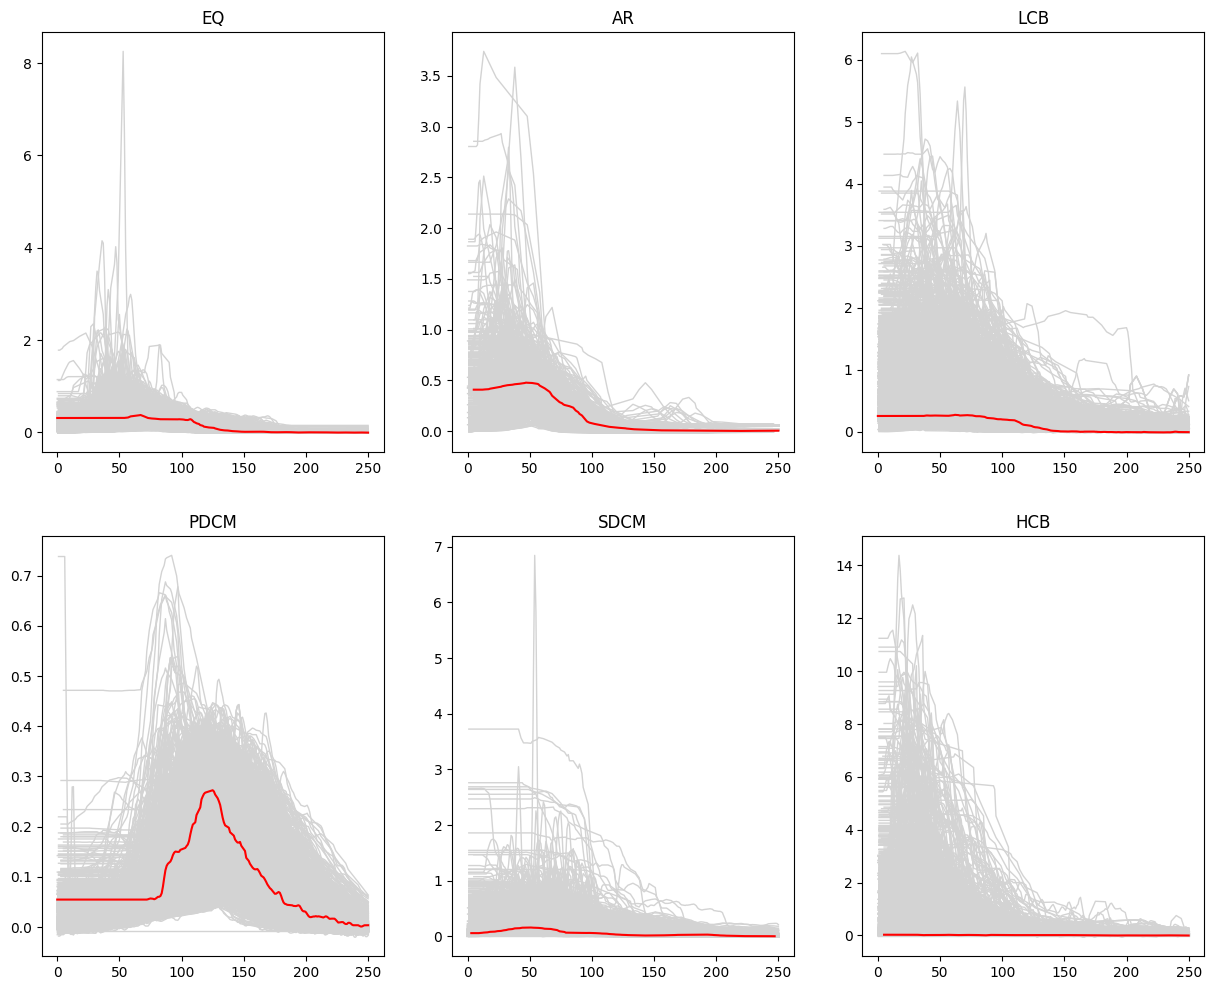

In [36]:
#View the distributions of floats within each cluster:
plt.figure(figsize=(15, 12))
for n, cluster_name in enumerate(cluster_names):
    cluster_float_cycles = train_set[train_set['cluster'] == cluster_name]['float_cycle']
    #pull 100 random samples to plot
    # randomlist = random.sample(range(0, len(cluster_float_cycles)), 100)
    plt.subplot(2,3, n + 1)
    small_df_full = chla_distribution[chla_distribution['float_cycle'].isin(cluster_float_cycles) ]
    for id in cluster_float_cycles:
        small_df = small_df_full[small_df_full['float_cycle']==id ]
        plt.plot(small_df['PRES'],small_df['CHLA'],color='lightgray',linewidth=1)
    plt.plot(small_df[['PRES','CHLA']].groupby('PRES').agg('mean'), color='red')
    plt.title(cluster_name)

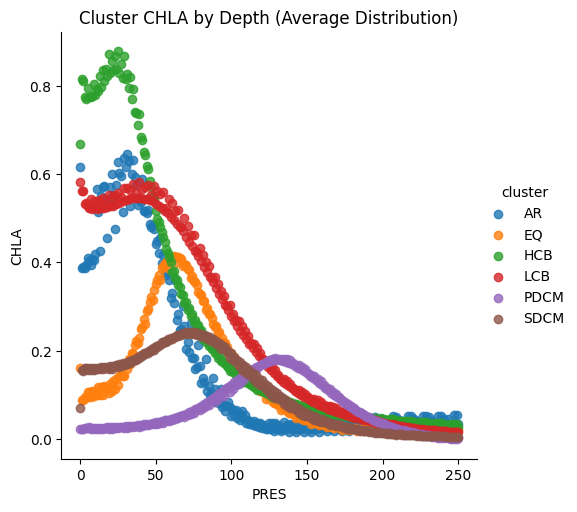

In [37]:
cluster_assignments = model_data[['cluster','float_cycle']]
#train_set[['cluster']].reset_index()
test = chla_distribution.merge(cluster_assignments, on='float_cycle')
test = test[['cluster','PRES','CHLA']].groupby(['cluster','PRES']).agg('mean').reset_index()
_ = sns.lmplot(x='PRES',y='CHLA', hue='cluster',data=test, fit_reg=False)
_ = plt.title('Cluster CHLA by Depth (Average Distribution)')
# _ = plt.gca().invert_yaxis()

In [28]:
# test.to_csv('../../data/cluster_chla_distribution.csv',index=False)

## KNN Classifier

In [27]:
drop_cols = ['float','cluster','cycleNumber','date','lon_bin','lat_bin']
index_col = 'float_cycle'
train_set_all_cols = train_set.dropna(inplace=False)
train_set_all_cols = train_set_all_cols.set_index([index_col])
test_set_all_cols = test_set.dropna(inplace=False)
test_set_all_cols = test_set_all_cols.set_index([index_col])
y_train, y_test = train_set_all_cols['cluster'], test_set_all_cols['cluster']
x_train, x_test = train_set_all_cols.drop(drop_cols, axis=1), test_set_all_cols.drop(drop_cols, axis=1)
x_train.head()

,day_of_year_rad,latitude,longitude,elevation,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season
float_cycle,,,,,,,,,,,,,,
2902086_3,0.017202,12.226748,88.674653,-3143.0,0.151244,29.029999,50.399902,0.001675,0.00001,0.0112,37.889999,0.001100,1,1
2902086_4,0.034405,12.255253,88.660667,-3137.0,0.148740,28.719999,49.199707,0.001615,0.00001,0.0110,23.099998,0.001070,1,1
2902086_5,0.051607,12.279345,88.662178,-3133.0,0.148740,28.719999,49.199707,0.001615,0.00001,0.0110,31.523998,0.001070,1,1
2902086_6,0.068810,12.305605,88.652755,-3129.0,0.143393,29.439999,47.600098,0.001560,0.00001,0.0111,45.358002,0.001045,1,1
2902086_7,0.086012,12.321588,88.645502,-3128.0,0.156987,29.119999,54.399902,0.001905,0.00001,0.0120,45.952000,0.001210,1,1


In [29]:
x_train.columns

Index(['day_of_year_rad', 'latitude', 'longitude', 'elevation', 'sat_chl',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_pic', 'sat_aph_443',
       'sat_par', 'sat_bb_678', 'month', 'season'],
      dtype='object')

In [30]:
#KNN with all variables
knn = KNeighborsClassifier(n_neighbors = 6, weights='distance').fit(x_train, y_train)
  
# accuracy on X_test
accuracy = knn.score(x_test, y_test)
print(accuracy)

0.8850574712643678


In [31]:
# training a KNN classifier without the month or elevation variable
drop_cols = ['float','cluster','cycleNumber','date','lon_bin','lat_bin']
index_col = 'float_cycle'
train_set_subset_cols = train_set.set_index([index_col])
test_set_subset_cols = test_set.set_index([index_col])
y_train, y_test = train_set_subset_cols['cluster'], test_set_subset_cols['cluster']
x_train, x_test = train_set_subset_cols.drop(drop_cols, axis=1), test_set_subset_cols.drop(drop_cols, axis=1)

knn = KNeighborsClassifier(n_neighbors = 6, weights='distance').fit(x_train[['day_of_year_rad', 'latitude', 'longitude', 'season']], y_train)
  
# accuracy on X_test
accuracy = knn.score(x_test[['day_of_year_rad', 'latitude', 'longitude', 'season']], y_test)
print(accuracy)

0.9822350753976451


In [32]:
knn_predictions = knn.predict(x_test[['day_of_year_rad', 'latitude', 'longitude', 'season']])

In [33]:
knn_results = pd.DataFrame(list(zip(knn_predictions, y_test)), columns=['y_hat','y_test'])
errors = dict(zip(list(cluster_names), [None]*len(cluster_names)))
knn_results['false_negative'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_test'],0)
# knn_results['false_positive'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_hat'],0)
knn_summary = pd.DataFrame(knn_results['false_negative'].value_counts()).reset_index()
overall_count = pd.DataFrame(knn_results['y_test'].value_counts()).reset_index()
knn_summary = knn_summary.merge(overall_count, on='index')
knn_summary.index = knn_summary['index']
knn_summary = knn_summary.drop('index',axis=1)
knn_summary.loc['Total'] = knn_summary.sum()
knn_summary['false_negative_pct'] = round(knn_summary['false_negative']/knn_summary['y_test']*100,0)
knn_summary


,false_negative,y_test,false_negative_pct
index,,,
HCB,37,932,4.0
LCB,35,1812,2.0
SDCM,11,677,2.0
EQ,3,642,0.0
Total,86,4063,2.0


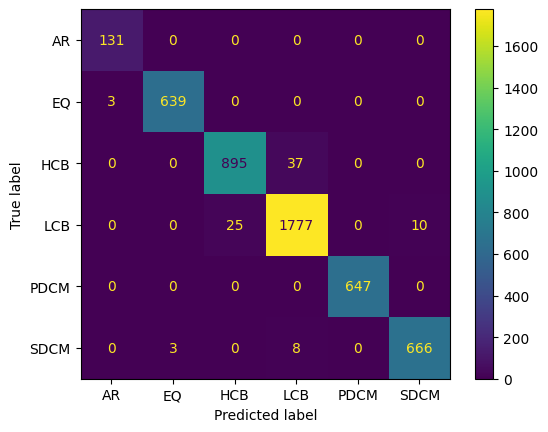

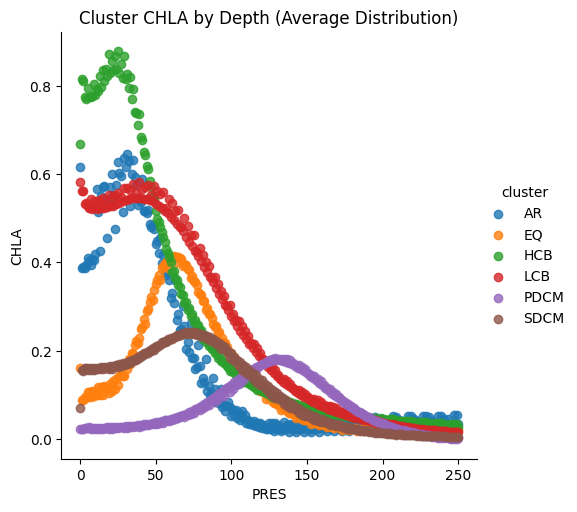

In [34]:
cm = confusion_matrix(y_test, knn_predictions, labels=sorted(cluster_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(cluster_names))
# plt.subplot(1,2,1)
disp.plot()
plt.show()
# plt.subplot(1,2,2)
cluster_assignments = model_data[['cluster','float_cycle']]
#train_set[['cluster']].reset_index()
test = chla_distribution.merge(cluster_assignments, on='float_cycle')
test = test[['cluster','PRES','CHLA']].groupby(['cluster','PRES']).agg('mean').reset_index()
_ = sns.lmplot(x='PRES',y='CHLA', hue='cluster',data=test, fit_reg=False)
_ = plt.title('Cluster CHLA by Depth (Average Distribution)')
# _ = plt.gca().invert_yaxis()

In [35]:
knn_results = pd.DataFrame(list(zip(knn_predictions, y_test)), columns=['y_hat','y_test'])
errors = dict(zip(list(cluster_names), [None]*len(cluster_names)))
# knn_results['false_negative'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_test'],0)
knn_results['false_positive'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_hat'],0)
knn_summary = pd.DataFrame(knn_results['false_positive'].value_counts()).reset_index()
overall_count = pd.DataFrame(knn_results['y_test'].value_counts()).reset_index()
knn_summary = knn_summary.merge(overall_count, on='index')
knn_summary.index = knn_summary['index']
knn_summary = knn_summary.drop('index',axis=1)
knn_summary.loc['Total'] = knn_summary.sum()
knn_summary['false_positive_pct'] = round(knn_summary['false_positive']/knn_summary['y_test']*100,0)
knn_summary

,false_positive,y_test,false_positive_pct
index,,,
LCB,45,1812,2.0
HCB,25,932,3.0
SDCM,10,677,1.0
EQ,3,642,0.0
AR,3,131,2.0
Total,86,4194,2.0


In [156]:
#Predict on new data
new_data = new_data.dropna(subset=['day_of_year_rad', 'latitude', 'longitude', 'season'])
new_data_prediction = knn.predict(new_data[['day_of_year_rad', 'latitude', 'longitude', 'season']])

In [158]:
#Save model
# pickle.dump(knn, open('../../models/knearestneighbors_cluster_classification','wb'))

In [159]:
# knn_model = pickle.load(open('../../models/knearestneighbors_cluster_classification','rb'))

In [160]:
#Get all cluster assignments and save for later use
new_data['cluster'] = new_data_prediction
new_data['prediction'] = 1
model_data['prediction'] = 0
full_data = pd.concat([model_data,new_data],axis=0)
# full_data.to_csv('../../data/cluster_classification_assignment.csv',index=False)

## One against rest models - (worse results than knn)

In [88]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [97]:
# training a OneVsRest classifier without the month or elevation variable
drop_cols = ['float','cluster','cycleNumber','date','lon_bin','lat_bin']
index_col = 'float_cycle'
train_set_subset_cols = train_set.set_index([index_col])
test_set_subset_cols = test_set.set_index([index_col])
y_train, y_test = train_set_subset_cols['cluster'], test_set_subset_cols['cluster']
x_train, x_test = train_set_subset_cols.drop(drop_cols, axis=1), test_set_subset_cols.drop(drop_cols, axis=1)

x_test = x_test[['day_of_year_rad', 'latitude', 'longitude', 'season']]
x_train = x_train[['day_of_year_rad', 'latitude', 'longitude', 'season']]


### Gradient Boosting Classifier

In [98]:
model = OneVsRestClassifier(GradientBoostingClassifier(random_state=0)).fit(x_train, y_train)
preds = model.predict(x_test)
model.score(x_test, y_test)

0.94525924395786

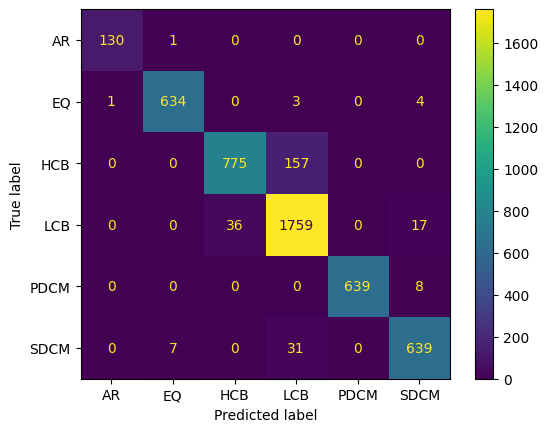

In [99]:
cm = confusion_matrix(y_test, preds, labels=sorted(cluster_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(cluster_names))
# plt.subplot(1,2,1)
disp.plot()
plt.show()

### Random Forest Classifier

In [100]:
model = OneVsRestClassifier(RandomForestClassifier(random_state=0)).fit(x_train, y_train)
preds = model.predict(x_test)
model.score(x_test, y_test)

0.9822350753976451

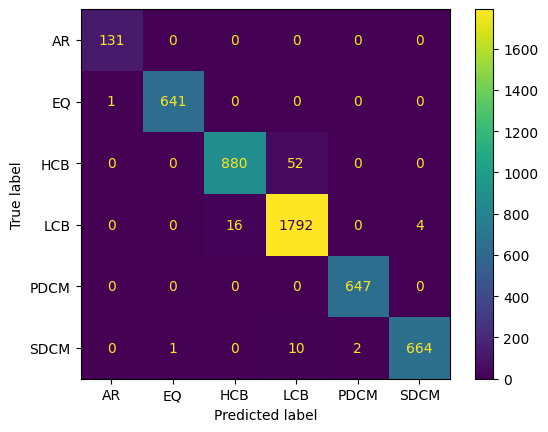

In [101]:
cm = confusion_matrix(y_test, preds, labels=sorted(cluster_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(cluster_names))
# plt.subplot(1,2,1)
disp.plot()
plt.show()